<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [1]:
# Import modules

import numpy as np
import scipy 
import seaborn as sns
import pandas as pd

import patsy

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
# Read csv files to DFs

businesses = pd.read_csv('../Extracted_Data/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('../Extracted_Data/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('../Extracted_Data/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('../Extracted_Data/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('../Extracted_Data/yelp_arizona_data/users_small_parsed.csv')

In [3]:
# Check shape and datatypes of all data

dfs = [businesses, checkins, reviews, tips, users]
dfs_names = ['businesses', 'checkins', 'reviews', 'tips', 'users']

for index, x in enumerate(dfs):
    print dfs_names[index]
    print 'Rows: ', x.shape[0]
    print 'Columns: ', x.shape[1]
    print x.info(),'\n'

businesses
Rows:  152832
Columns:  11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152832 entries, 0 to 152831
Data columns (total 11 columns):
business_id      152832 non-null object
name             152832 non-null object
review_count     152832 non-null int64
city             152832 non-null object
stars            152832 non-null float64
categories       152832 non-null object
latitude         152832 non-null float64
longitude        152832 non-null float64
neighborhoods    152832 non-null object
variable         152832 non-null object
value            152832 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 12.8+ MB
None 

checkins
Rows:  214299
Columns:  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214299 entries, 0 to 214298
Data columns (total 3 columns):
business_id    214299 non-null object
variable       214299 non-null object
value          214299 non-null float64
dtypes: float64(1), object(2)
memory usage: 4.9+ MB
None 

reviews
Rows:  32239

In [4]:
businesses.head().T

,0,1,2,3,4
business_id,EmzaQR5hQlF0WIl24NxAZA,SiwN7f0N4bs4ZtPc4yPgiA,e5kc0CQ4R-PCCDgb274gSg,neGAQFkBNI8-rpPBLBzNkw,45puCRQ6Vh_IIAy7kkfFDQ
name,Sky Lounge,Palazzo,Canyon Cafe,Taco Bell,Majerle's Sports Grill
review_count,25,19,238,10,205
city,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix
stars,2.5,3,3.5,4,3.5
categories,"['American (New)', 'Nightlife', 'Dance Clubs',...","['Bars', 'Nightlife', 'Dance Clubs']","['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']","['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...","['Bars', 'Restaurants', 'American (Traditional..."
latitude,33.4484,33.4559,33.4522,33.4654,33.4485
longitude,-112.072,-112.074,-112.069,-112.069,-112.071
neighborhoods,[],[],[],[],[]
variable,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey


In [5]:
# Question 1 / 2

# Add bool for Las Vegas

businesses_mod = businesses.copy()
businesses_mod['is_vegas'] = businesses_mod['city'].map(lambda x: 1 if x.lower() == 'las vegas' else 0)

# Define target and predictors

X = businesses_mod[['review_count', 'stars']]
y = businesses_mod['is_vegas']

# Initialize KNN classification model, with GridSearchCV

params = {
    'n_neighbors':range(1,101),
    'weights':['uniform','distance']
}

knn = KNeighborsClassifier()

knn_gs = GridSearchCV(knn, params, cv=5, verbose=1)

In [6]:
# Run GridSearchCV

knn_gs.fit(X, y)

print knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   32.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed: 13.1min


{'n_neighbors': 95, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 17.8min finished


In [7]:
# Use GridSearch'd params and print CV scores, compare to baseline

scores = cross_val_score(best_knn, X, y, cv=5)

print 'KNN CV scores:', scores
print 'KNN mean score:', np.mean(scores)
print 'Baseline accuracy:', np.mean(y)

KNN CV scores: [ 0.74488828  0.73998103  0.74894494  0.74609043  0.74320301]
KNN mean score: 0.744621536274
Baseline accuracy: 0.613863588777


In [8]:
businesses_mod.groupby(['city']).mean()

,review_count,stars,latitude,longitude,is_vegas
city,,,,,
Las Vegas,133.364674,3.474983,36.128327,-115.192257,1.0
Phoenix,87.031701,3.489471,33.523585,-112.056129,0.0
Surprise,43.865837,3.017989,33.634243,-112.376170,0.0
Waterloo,15.971749,3.520645,43.472572,-80.527774,0.0


In [9]:
businesses_mod.describe()

,review_count,stars,latitude,longitude,is_vegas
count,152832.00000,152832.000000,152832.000000,152832.000000,152832.000000
mean,113.35011,3.471966,35.304429,-113.417933,0.613864
std,262.24581,0.768355,1.669487,4.706022,0.486864
min,3.00000,1.000000,33.281526,-115.386550,0.000000
25%,12.00000,3.000000,33.582160,-115.194814,0.000000
50%,34.00000,3.500000,36.096639,-115.140690,1.000000
75%,101.00000,4.000000,36.135012,-112.074115,1.000000
max,5642.00000,5.000000,43.514662,-80.515244,1.000000


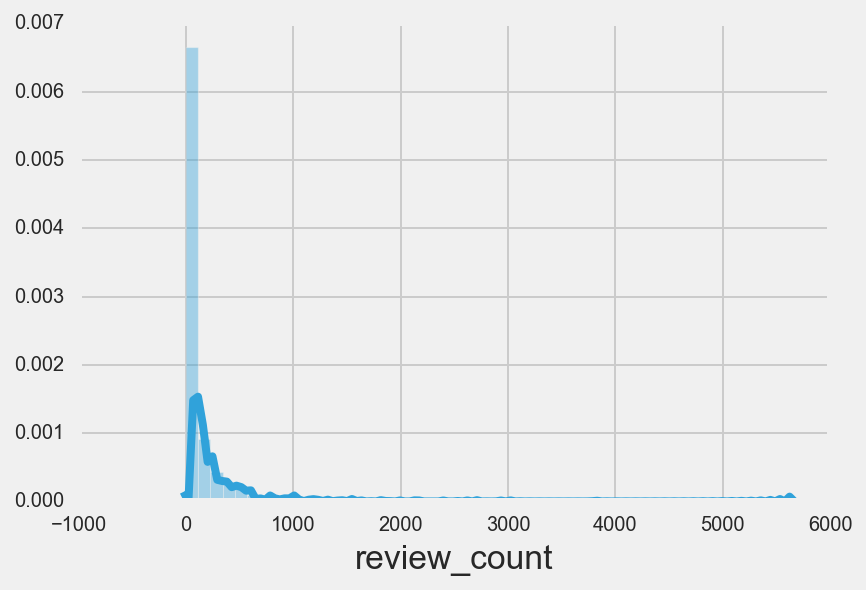

In [11]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()

ax = sns.distplot(businesses[businesses['city'] == 'Las Vegas'].review_count)
plt.show()

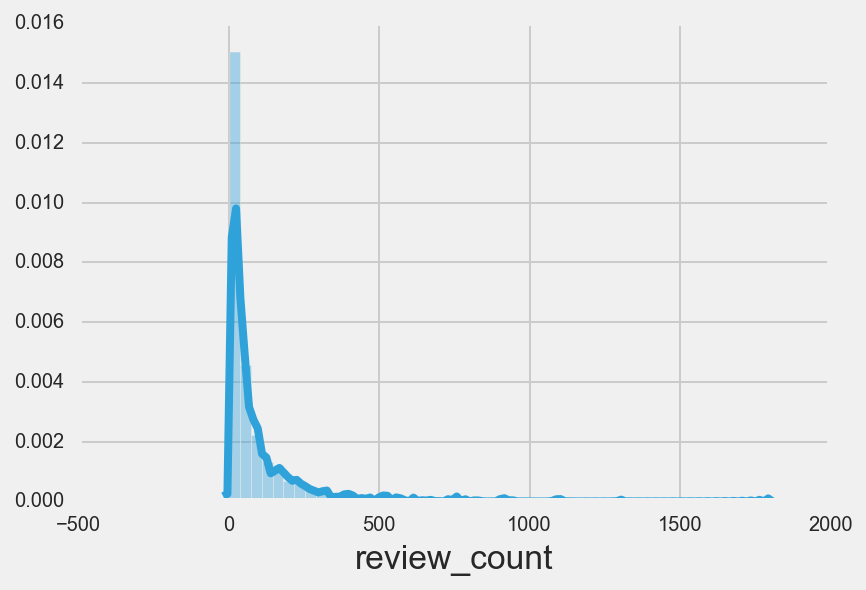

In [12]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()

ax = sns.distplot(businesses[businesses['city'] == 'Phoenix'].review_count)
plt.show()

In [ ]:
# Next step would be to add data from other tables. I have a sneaking suspicion that check-in times / frequency 
# would improve the results here. But I wanted to make sure I got to the other two problems. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [13]:
# Question 1 / Question 2

# Establish which columns are service related

base_cols = list(reviews.columns[0:8])

service_cols = [col for col in reviews.columns[8:] if 'service' in col]
service_cols.extend(['wait staff','right away','10 minutes','15 minutes','20 minutes','30 minutes'])

other_cols = [col for col in reviews.columns[8:] if col not in service_cols]

# Split reviews table into service related and non service related

service_reviews = reviews.ix[:,(base_cols + service_cols)]
other_reviews = reviews.ix[:, (base_cols + other_cols)]

print reviews.shape
print service_reviews.shape
print other_reviews.shape

(322398, 108)
(322398, 24)
(322398, 92)


In [14]:
# Create list of users who have the most service related word pairs in their reviews

user_list = service_reviews.groupby(['user_id'])[service_cols].sum().sum(axis=1).sort_values(ascending=False)

# Print summary statistics

print 'Users:', reviews['user_id'].unique().size
print 'Max reviews per user:', np.max(user_list)
print 'Min reviews per user:', np.min(user_list)
print 'Mean reviews per user:', np.mean(user_list)

# Some users are especially prolific (lots of outliers in distribution)

Users: 144206
Max reviews per user: 110
Min reviews per user: 0
Mean reviews per user: 0.558062771313


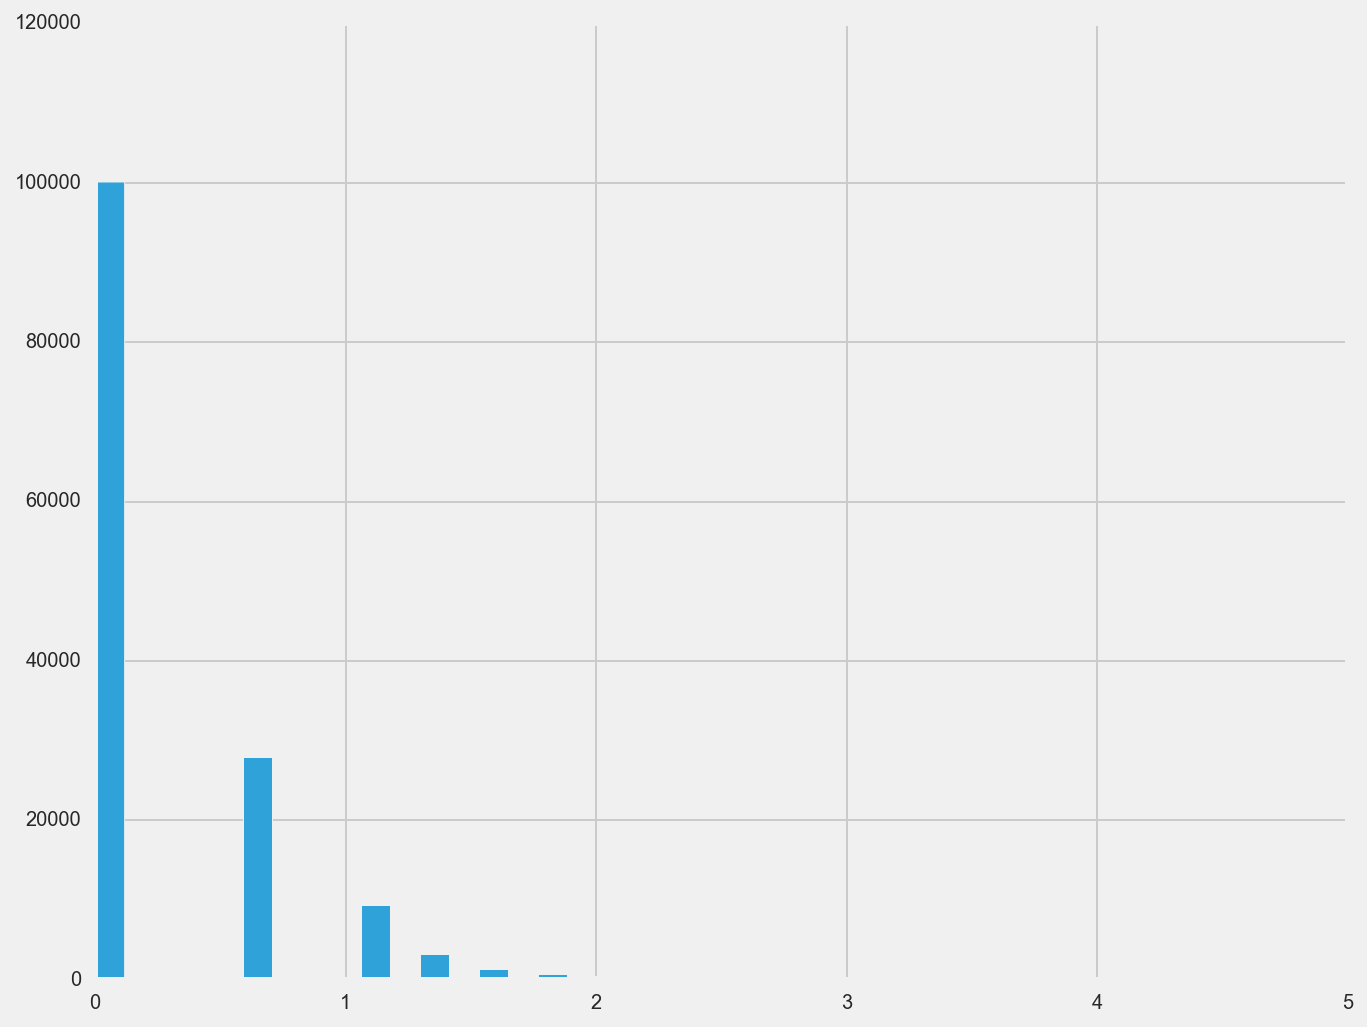

In [15]:
# Plot distribution (x-axis is logarithmic (ln)) 

fig, ax = plt.subplots(figsize=(10,8))
user_list.map(lambda x: np.log(1 + x)).hist(bins=40, ax=ax)
plt.show()

In [16]:
# Question 3 / 4, Part 1 (Run CV LinearRegression on entire service focused dataset)

# Establish excluded columns and create X and y 

excluded_cols = ['stars', 'business_id', 'user_id', 'business_id', 'review_id', 'date']
X = service_reviews[[col for col in service_reviews.columns if col not in excluded_cols]]
y = service_reviews['stars']

# Initialize, fit, CV, and score LinearRegression

linreg = LinearRegression()
linreg.fit(X, y)
lr_scores = cross_val_score(linreg, X, y, cv=5)

print 'R2 scores: ', lr_scores
print 'Mean R2: ', np.mean(lr_scores)

R2 scores:  [ 0.07719527  0.07780093  0.07634872  0.10348139  0.10114397]
Mean R2:  0.0871940573748


In [17]:
# Create function to optimize CV LinReg score by subsetting review data by only reviews that 
# have received a specified number of votes in a specified category (e.g. useful, cool, funny)

def votes_optimizer(df, kind='votes.useful', votes=5, sort=False, folds=5):
    
    output_dict = {
        kind       : [],
        'R2_score' : []
    }
    
    excluded_cols = ['stars', 'business_id', 'user_id', 'business_id', 'review_id', 'date']

    # Simulate different subsetting conditions     
    for i in range(0, votes + 1):
        
        # Create new df using iterator to subset original df by votes       
        df_sub = df[df[kind] > i]

        # Create X and y variables
        X = df_sub[[col for col in df_sub.columns if col not in excluded_cols]]
        y = df_sub['stars']

        # Initialize, fit, CV, and score LinearRegression
        linreg = LinearRegression()
        linreg.fit(X, y)

        output_dict[kind].append(i)
        output_dict['R2_score'].append(np.mean(cross_val_score(linreg, X, y, cv=folds)))
        
    if sort:
        return pd.DataFrame(output_dict, columns=[kind, 'R2_score']).sort_values(by='R2_score', ascending=False)
    else:
        return pd.DataFrame(output_dict, columns=[kind, 'R2_score'])

In [18]:
# Use custom function to return top results

votes_optimizer(service_reviews, votes=30, kind='votes.useful', sort=True).head()

,votes.useful,R2_score
15,15,0.359375
13,13,0.352624
14,14,0.351235
12,12,0.350956
11,11,0.346101


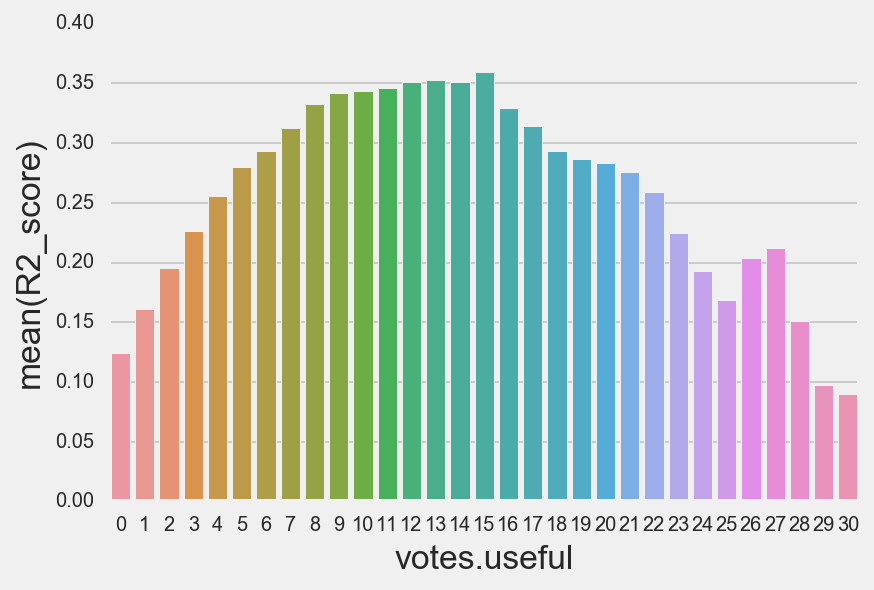

In [19]:
# Use custom function to return graph of R2 score for different subset values

graph_df = votes_optimizer(service_reviews, votes=30, kind='votes.useful')

sns.barplot(graph_df['votes.useful'], graph_df['R2_score'])
plt.show()

In [20]:
# Refit LinearRegression model using optimized parameters

service_reviews_sub = service_reviews[service_reviews['votes.useful'] > 15]

X = service_reviews_sub[[col for col in service_reviews_sub.columns if col not in excluded_cols]]
y = service_reviews_sub['stars']

linreg = LinearRegression()
linreg.fit(X, y)
lr_scores = cross_val_score(linreg, X, y, cv=5)

print 'R2 scores: ', lr_scores
print 'Mean R2: ', np.mean(lr_scores)

R2 scores:  [ 0.3789642   0.3170019   0.30794863  0.46349513  0.32946561]
Mean R2:  0.359375094439


In [21]:
# Evaluate coefficients and isolate variables that are most predictive 

coefs = pd.DataFrame({'coef':linreg.coef_, 'abs_coef':np.abs(linreg.coef_), 'variable':[col for col in X.columns]})
coefs.sort_values(by='abs_coef', ascending=False).head(10)

,abs_coef,coef,variable
16,0.510687,-0.510687,15 minutes
17,0.496928,-0.496928,20 minutes
8,0.458759,0.458759,service excellent
3,0.407387,0.407387,bottle service
18,0.375782,-0.375782,30 minutes
6,0.323407,0.323407,good service
4,0.300947,-0.300947,customer service
11,0.265059,-0.265059,service good
9,0.264589,-0.264589,service food
12,0.219242,-0.219242,service great


In [22]:
# Question 3 / 4, Part 2 (Run CV LinearRegression on entire non-service focused dataset)

# Establish excluded columns and create X and y 

excluded_cols = ['stars', 'business_id', 'user_id', 'business_id', 'review_id', 'date']
X = other_reviews[[col for col in other_reviews.columns if col not in excluded_cols]]
y = other_reviews['stars']

# Initialize, fit, CV, and score LinearRegression

linreg = LinearRegression()
linreg.fit(X, y)
lr_scores = cross_val_score(linreg, X, y, cv=5)

print 'R2 scores: ', lr_scores
print 'Mean R2: ', np.mean(lr_scores)

R2 scores:  [ 0.12344962  0.13112839  0.12217174  0.15557357  0.16442623]
Mean R2:  0.139349911537


In [23]:
# Use function to return top results

votes_optimizer(other_reviews, votes=20, kind='votes.useful', sort=True).head()

,votes.useful,R2_score
12,12,0.348977
9,9,0.346926
10,10,0.345639
11,11,0.345473
13,13,0.344016


In [24]:
# Refit LinearRegression model using optimized parameters

other_reviews_sub = other_reviews[other_reviews['votes.useful'] > 12]

X = other_reviews_sub[[col for col in other_reviews_sub.columns if col not in excluded_cols]]
y = other_reviews_sub['stars']

linreg = LinearRegression()
linreg.fit(X, y)
lr_scores = cross_val_score(linreg, X, y, cv=5)

print 'R2 scores: ', lr_scores
print 'Mean R2: ', np.mean(lr_scores)

R2 scores:  [ 0.34695277  0.31144783  0.31536762  0.43022397  0.34089388]
Mean R2:  0.348977216827


In [25]:
# Evaluate coefficients and isolate variables that are most predictive 

coefs = pd.DataFrame({'coef':linreg.coef_, 'abs_coef':np.abs(linreg.coef_), 'variable':[col for col in X.columns]})
coefs.sort_values(by='abs_coef', ascending=False).head(10)

,abs_coef,coef,variable
11,0.852632,0.852632,definitely recommend
44,0.637936,0.637936,highly recommend
27,0.613942,-0.613942,food just
4,0.553012,0.553012,beer selection
48,0.534159,-0.534159,just ok
12,0.503780,-0.503780,didn want
5,0.494140,0.494140,best ve
57,0.449349,0.449349,love place
80,0.448160,0.448160,super friendly
55,0.426264,-0.426264,looked like


In [26]:
# Both regressions (service / non-service related) have R2 scores ~0.35, but achieve it via different 
# predictor variables. The score was optimized in both cases using a subsetting mechanism, whereby reviews 
# that had not recieved many votes.useful by the community, were filtered out. 
#
# At first glance, the coefficient values dont appear heavily concentrated. However, many of the 
# variables are related to one another (e.g. "definitely recommend" / "highly recommend", or 
# "service excellent" / "good service"). This implies that the most predictive word 
# pairs are those that reflect a strong positive statement about service or the restaurant in general. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [41]:
users.head().T

,0,1,2,3,4
yelping_since,2004-10,2004-10,2004-10,2004-10,2004-10
compliments.plain,959,89,2,5,104
review_count,1274,442,66,101,983
compliments.cute,206,23,2,1,82
compliments.writer,327,24,2,3,17
fans,1179,100,4,7,78
compliments.note,611,83,1,3,85
compliments.hot,1094,101,1,5,265
compliments.cool,1642,145,1,4,212
compliments.profile,116,9,NaN,1,9


In [28]:
# Clean users table. Convert 'lists' to lists, then designate users as 'elite' if they have been elite 
# for at least one year. Increasing this threshold will improve the R2. 

from ast import literal_eval

users_clean = users.copy()

users_clean['elite'] = users_clean['elite'].map(lambda x: literal_eval(x))
users_clean['is_elite'] = users_clean['elite'].map(lambda x: 1 if len(x) > 0 else 0)

In [29]:
# To simplify analysis, I will only focus on variables that have complete data. Therefore, I am exluding 
# the 'compliments' related columns. These variables are not expected to have large predictive power but 
# can be revisited if need be. 
#
# Define X and y, and verify that there are no missing values in the predictors. 

excluded_cols = [col for col in users_clean.columns if 'compliments' in col] 
excluded_cols = excluded_cols + ['yelping_since', 'elite', 'votes.cool', 'user_id', 'name', 'is_elite'] 
predictors = [col for col in users_clean.columns if col not in excluded_cols]

y = users_clean['is_elite']
X = users_clean[predictors]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 5 columns):
review_count     144206 non-null int64
fans             144206 non-null int64
average_stars    144206 non-null float64
votes.funny      144206 non-null int64
votes.useful     144206 non-null int64
dtypes: float64(1), int64(4)
memory usage: 5.5 MB


In [30]:
# Evaluate colinearity among predictors

X.corr()

,review_count,fans,average_stars,votes.funny,votes.useful
review_count,1.000000,0.599495,-0.005049,0.541561,0.670673
fans,0.599495,1.000000,0.009711,0.763179,0.821060
average_stars,-0.005049,0.009711,1.000000,0.001297,0.000787
votes.funny,0.541561,0.763179,0.001297,1.000000,0.955130
votes.useful,0.670673,0.821060,0.000787,0.955130,1.000000


In [31]:
# Question 1 / 2
#
# Initialize and fit LogisticRegression model

ss = StandardScaler()
Xn = ss.fit_transform(X)

lr = LogisticRegression()
lr.fit(Xn, y)

lr_scores = cross_val_score(lr, Xn, y, cv=5)

In [32]:
# Evaluate CV results of LogisticRegression model and compare to baseline

print 'R2 scores:', lr_scores
print 'Mean R2:', np.mean(lr_scores)
print 'Baseline Model:', np.mean(y)

R2 scores: [ 0.9449414   0.94525345  0.94393593  0.9435853   0.94153953]
Mean R2: 0.943851121626
Baseline Model: 0.115272596147


In [33]:
# Evaluate coefficients and isolate variables that are most predictive 
#
# Results indicate that votes.useful are the biggest driver in whether a user is 'elite' or not. Number of fans 
# and reviews posted are also contributing variables. The negative sign associated with votes.funny likely has to
# do with colinearity among the predictors. 

coefs = pd.DataFrame({'coef':lr.coef_[0], 'abs_coef':np.abs(lr.coef_[0]), 'variable':[col for col in X.columns]})
coefs.sort_values(by='abs_coef', ascending=False)

,abs_coef,coef,variable
4,4.297548,4.297548,votes.useful
3,2.880966,-2.880966,votes.funny
1,1.939288,1.939288,fans
0,1.857791,1.857791,review_count
2,0.208253,0.208253,average_stars


In [34]:
# Rerun the same model, but utilize GridSearch
#
# Initialize and fit GridSearch LogisticRegression model

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 50)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)
lr_gs.fit(Xn, y)

print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

lr_gs_scores = cross_val_score(best_lr, Xn, y, cv=5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.4min finished


{'penalty': 'l2', 'C': 102.04090612244897, 'solver': 'liblinear'}


In [35]:
# Evaluate CV results of LogisticRegression model and compare to baseline
#
# Surprised there is such a small difference between the GridSearch results
# ...?

print 'R2 scores:', lr_gs_scores
print 'Mean R2:', np.mean(lr_gs_scores)
print 'Baseline Model:', np.mean(y)

R2 scores: [ 0.94497608  0.94535746  0.94386658  0.94351595  0.94174757]
Mean R2: 0.943892729541
Baseline Model: 0.115272596147


In [36]:
# Evaluate coefficients and isolate variables that are most predictive 

coefs = pd.DataFrame({'coef':best_lr.coef_[0], 'abs_coef':np.abs(best_lr.coef_[0]), 'variable':[col for col in X.columns]})
coefs.sort_values(by='abs_coef', ascending=False)

,abs_coef,coef,variable
4,4.416432,4.416432,votes.useful
3,2.982911,-2.982911,votes.funny
1,1.941609,1.941609,fans
0,1.844000,1.844000,review_count
2,0.208785,0.208785,average_stars


In [37]:
# Question 3 
#
# Filter out counts related metrics (just to see which columns are left)

counts_out = [col for col in users_clean.columns if 'review' not in col]
counts_out = [col for col in counts_out if 'votes' not in col]
counts_out = [col for col in counts_out if 'compliments' not in col] 

# Add column that converts 'yelping since' to number of years yelping

users_clean['years_yelping'] = users_clean['yelping_since'].map(lambda x: 2016 - int(x[:4]))

In [38]:
# Initialize and fit LogisticRegression model

X = users_clean[['fans', 'years_yelping', 'average_stars']]
y = users_clean['is_elite']

ss = StandardScaler()
Xn = ss.fit_transform(X)

lr = LogisticRegression()
lr.fit(Xn, y)

lr_scores = cross_val_score(lr, Xn, y, cv=5)

In [39]:
print 'R2 scores:', lr_scores
print 'Mean R2:', np.mean(lr_scores)
print 'Baseline Model:', np.mean(y)

R2 scores: [ 0.93994869  0.93752167  0.93616948  0.93457004  0.93231623]
Mean R2: 0.936105219975
Baseline Model: 0.115272596147


In [40]:
# Much better than I expected, apparantly fans is quite the predictor

coefs = pd.DataFrame({'coef': lr.coef_[0], 'abs_coef': np.abs(lr.coef_[0]), 'variable':[col for col in X.columns]})
coefs.sort_values(by='abs_coef', ascending=False)

,abs_coef,coef,variable
0,6.168995,6.168995,fans
1,0.529743,0.529743,years_yelping
2,0.063913,0.063913,average_stars


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?